# Problem description: 
### Use machine learning to predict the survival rate (0 or 1) of passengers on titanic in the test set using existing training data set

### Details: https://www.kaggle.com/c/titanic

### Step 1. Upload libraries and training/testing dataset
#### (a) Let’s begin with common Python data parse and visualization packages (numpy, pandas, matplotlib) and a variety of scikit-learn models for scanning. We also need to import scikit learn model_selection module for parameter optimization.

In [4]:
%matplotlib inline
import csv as csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

#### (b) Read training and testing dataset into pandas dataframe 

In [5]:
# (row 0 is the header row)
train = pd.read_csv('train.csv', header = 0)
test = pd.read_csv('test.csv', header = 0)

### Step 2. Training data analysis to get quantitative intuition about the training data set.

In [6]:
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


#### (a) Check missing values

In [8]:
train.isnull().sum() 
# age (missing 177/891 values), embarked (missing 2 values), cabin (missing 687/891 values)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

#### (b) Check distribution of people by sex, class, number of sibling/spouse, parents/children, survival or not, embarking location

In [9]:
print(train.groupby('Sex').size())
print(train.groupby('Pclass').size())
print(train.groupby('SibSp').size())
print(train.groupby('Parch').size())
print(train.groupby('Survived').size())
print(train.groupby('Embarked').size())

Sex
female    314
male      577
dtype: int64
Pclass
1    216
2    184
3    491
dtype: int64
SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
dtype: int64
Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
dtype: int64
Survived
0    549
1    342
dtype: int64
Embarked
C    168
Q     77
S    644
dtype: int64


### Step 3. Preliminary data cleaning
#### To format/clean some intuitive data including sex, age, PassengerId and FamilySize for further visualization and analysis.

In [10]:
# map Sex into numerical values
train['Sex'] = train['Sex'].map({'male':1,'female':0})

# fill age NUll with average values based on Gender and Pclass
train['AgeFill'] = train['Age']
median_train_ages = np.zeros((2,3))
for i in range(0, 2):
    for j in range(0, 3):
        median_train_ages[i,j] = train[(train['Sex'] == i) & (train['Pclass'] 
                                            == j+1)]['Age'].dropna().median()
for i in range(0, 2):
    for j in range(0, 3):
        train.loc[(train.Age.isnull()) & (train.Sex == i) & (train.Pclass ==
                                        j+1), 'AgeFill'] = median_train_ages[i,j]

train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
train = train.drop(['PassengerId', 'Cabin', 'Age', 'Ticket'], axis=1)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      889 non-null object
AgeFill       891 non-null float64
FamilySize    891 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 69.7+ KB


### Step 4. visualize/analyze train data
### Goal: To visualize train data in search for preliminary correlation between survival and other numerical parameters.

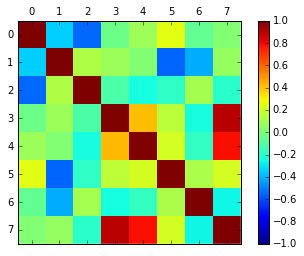

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
Survived      891 non-null int64
Pclass        891 non-null int64
Name          891 non-null object
Sex           891 non-null int64
SibSp         891 non-null int64
Parch         891 non-null int64
Fare          891 non-null float64
Embarked      889 non-null object
AgeFill       891 non-null float64
FamilySize    891 non-null int64
dtypes: float64(2), int64(6), object(2)
memory usage: 69.7+ KB


In [11]:
# correlation matrix
# 'survived' + other 7 numerical features
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(train.corr(), vmin = -1, vmax = 1, interpolation = 'none')
fig.colorbar(cax)
plt.show()
# negatively correlated with Sex, Pclass; positively correlated with Fare, Parch
train.info()

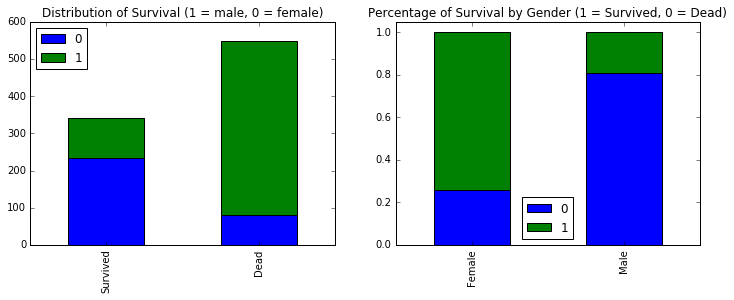

In [12]:
# Sex: women are more likely to survive, female: 0, male: 1

fig, axes = plt.subplots(nrows = 1, ncols = 2)

survived_sex = train[train['Survived'] == 1]['Sex'].value_counts()
dead_sex = train[train['Survived'] == 0]['Sex'].value_counts()
df1 = pd.DataFrame([survived_sex,dead_sex])
df1.index = ['Survived','Dead']
df1.plot(kind = 'bar',stacked = True, figsize = (12,4), ax = axes[0], title = "Distribution of Survival (1 = male, 0 = female)")

female_count, male_count = train.groupby('Sex').size()
female = train[train['Sex'] == 0]['Survived'].value_counts()/float(female_count)
male = train[train['Sex'] == 1]['Survived'].value_counts()/float(male_count)
df2 = pd.DataFrame([female, male])
df2.index = ['Female','Male']
df2.plot(kind = 'bar',stacked = True, figsize = (12,4), ylim = (0, 1.05), ax = axes[1],\
         title = "Percentage of Survival by Gender (1 = Survived, 0 = Dead)")

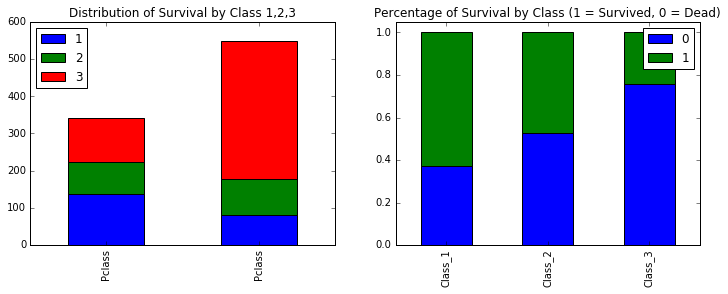

In [13]:
# Pclass: survival rate: first class > second class > third class
fig, axes = plt.subplots(nrows = 1, ncols = 2)

survived_class = train[train['Survived'] == 1]['Pclass'].value_counts()
dead_class = train[train['Survived'] == 0]['Pclass'].value_counts()
df1 = pd.DataFrame([survived_class,dead_class])
#df1.index = ['Survived','Dead']
df1.plot(kind = 'bar',stacked = True, figsize = (12,4), ax = axes[0], title = "Distribution of Survival by Class 1,2,3")

class1, class2, class3 = train.groupby('Pclass').size()
Pclass1 = train[train['Pclass'] == 1]['Survived'].value_counts()/float(class1)
Pclass2 = train[train['Pclass'] == 2]['Survived'].value_counts()/float(class2)
Pclass3 = train[train['Pclass'] == 3]['Survived'].value_counts()/float(class3)
df2 = pd.DataFrame([Pclass1, Pclass2, Pclass3])
df2.index = ['Class_1','Class_2', 'Class_3']
df2.plot(kind = 'bar',stacked = True, figsize = (12,4), ylim = (0, 1.05), ax = axes[1],\
         title = "Percentage of Survival by Class (1 = Survived, 0 = Dead)")

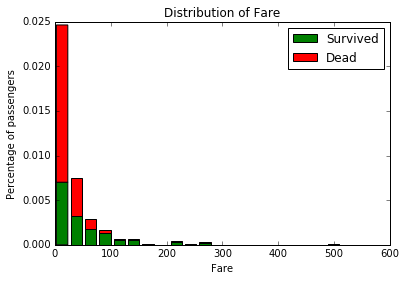

In [14]:
# fare: low fare less likely to survive
figure = plt.figure(figsize = (6, 4))
plt.hist([train[train['Survived'] == 1]['Fare'],train[train['Survived'] == 0]['Fare']], stacked = True, color = ['g','r'],
         bins = 20,label = ['Survived','Dead'], normed = True, log = False)
plt.xlabel('Fare')
plt.ylabel('Percentage of passengers')
plt.legend()
plt.title("Distribution of Fare")

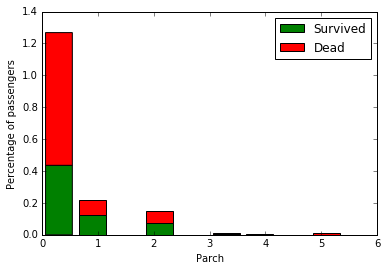

In [15]:
# Parch: singlets or families with too many Parch are more likely to die 
figure = plt.figure(figsize = (6, 4))
plt.hist([train[train['Survived'] == 1]['Parch'],train[train['Survived'] == 0]['Parch']], stacked = True, color = ['g','r'],
         label = ['Survived','Dead'], normed = True)
plt.xlabel('Parch')
plt.ylabel('Percentage of passengers')
plt.legend()

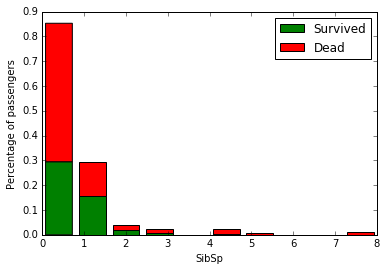

In [16]:
# SibSp: singleton or people with over 4 Sibling+Spouse are more likely to die.
figure = plt.figure(figsize = (6, 4))
plt.hist([train[train['Survived'] == 1]['SibSp'],train[train['Survived'] == 0]['SibSp']], stacked = True, color = ['g','r'],
         label = ['Survived','Dead'], normed = True)
plt.xlabel('SibSp')
plt.ylabel('Percentage of passengers')
plt.legend()

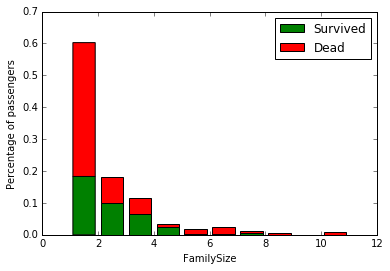

In [17]:
# FamilySize: Survival rate: singlets or Families with over 4 people < mid-sized family
figure = plt.figure(figsize = (6, 4))
plt.hist([train[train['Survived'] == 1]['FamilySize'],train[train['Survived'] == 0]['FamilySize']], stacked = True, color = ['g','r'],
         label = ['Survived','Dead'], normed = True)
plt.xlabel('FamilySize')
plt.ylabel('Percentage of passengers')
plt.legend()

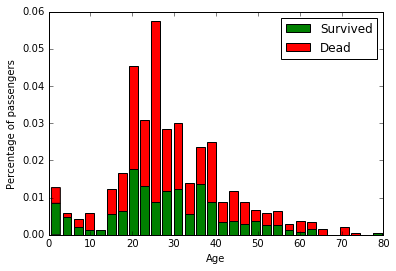

In [18]:
# age: kids below 10 are more likely to survive, older than 65 are less likely.
figure = plt.figure(figsize = (6,4))
plt.hist([train[train['Survived'] == 1]['AgeFill'],train[train['Survived'] == 0]['AgeFill']],
         stacked = True, color = ['g','r'],bins = 30,label = ['Survived','Dead'], normed = True)
plt.xlabel('Age')
plt.ylabel('Percentage of passengers')
plt.legend()

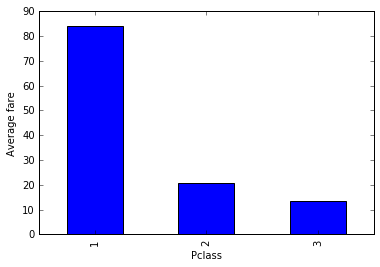

In [19]:
# ticket fare corelate with class
ax = plt.subplot()
ax.set_ylabel('Average fare')
train.groupby('Pclass').mean()['Fare'].plot(kind='bar',figsize=(6,4), ax = ax)

### Step 5. Feature engineering
#### Engineer features and further cleaning data based on intuition on the data from previous analysis
#### 1) map all object into numerical values 2) change all multivariant into binary(0, 1)/dummy columns 3) remove useless columns

In [20]:
# combine train and test data so that their features are engineered in the same way
# the only difference between test data and training data is that test data doesn't have 'Survived' column.
def get_combined_data():
    # reading train data
    train = pd.read_csv('train.csv', header=0)
    test = pd.read_csv('test.csv', header=0)
    
    # extracting and then removing the targets from the training data 
    target = train['Survived']
    train.drop('Survived', 1, inplace=True)

    # merging train data and test data for future feature engineering
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop(['index', 'PassengerId'],inplace=True,axis=1)
    
    return combined, target
    
combined, train_y = get_combined_data()

combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 10 columns):
Pclass      1309 non-null int64
Name        1309 non-null object
Sex         1309 non-null object
Age         1046 non-null float64
SibSp       1309 non-null int64
Parch       1309 non-null int64
Ticket      1309 non-null object
Fare        1308 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
dtypes: float64(2), int64(3), object(5)
memory usage: 102.3+ KB


In [21]:
combined['Name']

0                                 Braund, Mr. Owen Harris
1       Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                  Heikkinen, Miss. Laina
3            Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                                Allen, Mr. William Henry
5                                        Moran, Mr. James
6                                 McCarthy, Mr. Timothy J
7                          Palsson, Master. Gosta Leonard
8       Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)
9                     Nasser, Mrs. Nicholas (Adele Achem)
10                        Sandstrom, Miss. Marguerite Rut
11                               Bonnell, Miss. Elizabeth
12                         Saundercock, Mr. William Henry
13                            Andersson, Mr. Anders Johan
14                   Vestrom, Miss. Hulda Amanda Adolfina
15                       Hewlett, Mrs. (Mary D Kingcome) 
16                                   Rice, Master. Eugene
17            

In [22]:
# extract name, title etc from 'Name' column
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import itertools

vectorizer = CountVectorizer()
y = vectorizer.fit_transform(itertools.chain(combined['Name']))

name = vectorizer.get_feature_names()
count = np.sum(y.toarray(), axis=0)
ntoc = list(zip(name, count))
ntoc.sort(key=lambda x: x[1], reverse=True)
print(ntoc)

# most frequently appeared title： mr, miss, mrs, master, jr

[('mr', 763), ('miss', 260), ('mrs', 201), ('william', 87), ('john', 72), ('master', 61), ('henry', 49), ('charles', 40), ('james', 38), ('george', 37), ('thomas', 36), ('joseph', 31), ('mary', 30), ('edward', 28), ('elizabeth', 25), ('johan', 22), ('frederick', 21), ('alexander', 20), ('arthur', 20), ('samuel', 20), ('alfred', 18), ('anna', 18), ('maria', 18), ('robert', 18), ('richard', 16), ('albert', 14), ('frank', 14), ('jr', 14), ('karl', 14), ('margaret', 14), ('peter', 13), ('alice', 12), ('andersson', 12), ('ernest', 12), ('patrick', 12), ('annie', 11), ('harry', 11), ('sage', 11), ('edith', 10), ('ellen', 10), ('helen', 10), ('kate', 10), ('leonard', 10), ('martin', 10), ('walter', 10), ('catherine', 9), ('david', 9), ('de', 9), ('elias', 9), ('francis', 9), ('asplund', 8), ('august', 8), ('brown', 8), ('carl', 8), ('daniel', 8), ('dr', 8), ('goodwin', 8), ('louise', 8), ('rev', 8), ('van', 8), ('victor', 8), ('benjamin', 7), ('bertha', 7), ('bertram', 7), ('davies', 7), ('em

In [23]:
def get_titles():
    global combined
    
    # we extract the title from each name
    combined['Title'] = combined['Name'].map(lambda name:name.split(',')[1].
                        split('.')[0].strip())
    titles = combined['Title'].unique()
    print(titles)
    # a map of more aggregated titles
    Title_Dictionary = {
                        "Capt":       "Officer",
                        "Col":        "Officer",
                        "Major":      "Officer",
                        "Jonkheer":   "Royalty",
                        "Don":        "Royalty",
                        "Sir" :       "Royalty",
                        "Dr":         "Officer",
                        "Rev":        "Officer",
                        "the Countess":"Royalty",
                        "Dona":       "Royalty",
                        "Mme":        "Mrs",
                        "Mlle":       "Miss",
                        "Ms":         "Mrs",
                        "Mr" :        "Mr",
                        "Mrs" :       "Mrs",
                        "Miss" :      "Miss",
                        "Master" :    "Master",
                        "Lady" :      "Royalty"

                        }
    
    # we map each title
    combined['Title'] = combined.Title.map(Title_Dictionary)

get_titles()
# combined['Title'].isnull().sum()  # return 0, all values are mapped

['Mr' 'Mrs' 'Miss' 'Master' 'Don' 'Rev' 'Dr' 'Mme' 'Ms' 'Major' 'Lady'
 'Sir' 'Mlle' 'Col' 'Capt' 'the Countess' 'Jonkheer' 'Dona']


In [24]:
# Let's create a function that fills in the missing age in combined based on 
# sex, Pclass, Title

grouped = combined.groupby(['Sex','Pclass','Title'])
grouped.median()

Age  SibSp  Parch      Fare
Sex    Pclass Title                                
female 1      Miss     30.0      0      0   99.9625
              Mrs      45.0      1      0   78.1125
              Officer  49.0      0      0   25.9292
              Royalty  39.0      0      0   86.5000
       2      Miss     20.0      0      0   20.2500
              Mrs      30.0      1      0   26.0000
       3      Miss     18.0      0      0    8.0500
              Mrs      31.0      1      1   15.5000
male   1      Master    6.0      1      2  134.5000
              Mr       41.5      0      0   47.1000
              Officer  52.0      0      0   37.5500
              Royalty  40.0      0      0   27.7208
       2      Master    2.0      1      1   26.0000
              Mr       30.0      0      0   13.0000
              Officer  41.5      0      0   13.0000
       3      Master    6.0      3      1   22.3583
              Mr       26.0      0      0    7.8958

In [25]:
def process_age():    
    global combined   
    # a function that fills the missing values of the Age variable   
    def fillAges(row):
        if row['Sex'] == 'female' and row['Pclass'] == 1:
            if row['Title'] == 'Miss':
                return 30
            elif row['Title'] == 'Mrs':
                return 45
            elif row['Title'] == 'Officer':
                return 49
            elif row['Title'] == 'Royalty':
                return 39

        elif row['Sex'] == 'female' and row['Pclass'] == 2:
            if row['Title'] == 'Miss':
                return 20
            elif row['Title'] == 'Mrs':
                return 30

        elif row['Sex'] == 'female' and row['Pclass'] == 3:
            if row['Title'] == 'Miss':
                return 18
            elif row['Title'] == 'Mrs':
                return 31

        elif row['Sex'] == 'male' and row['Pclass'] == 1:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 41.5
            elif row['Title'] == 'Officer':
                return 52
            elif row['Title'] == 'Royalty':
                return 40

        elif row['Sex'] == 'male' and row['Pclass'] == 2:
            if row['Title'] == 'Master':
                return 2
            elif row['Title'] == 'Mr':
                return 30
            elif row['Title'] == 'Officer':
                return 41.5

        elif row['Sex'] == 'male' and row['Pclass'] == 3:
            if row['Title'] == 'Master':
                return 6
            elif row['Title'] == 'Mr':
                return 26    
    combined.Age = combined.apply(lambda r : fillAges(r) if np.isnan(r['Age'])
                                                        else r['Age'], axis=1)

process_age()


In [26]:
# process fare by the mean value
def process_fares():
    
    global combined
    combined.Fare.fillna(combined.Fare.mean(),inplace=True) 

process_fares()

In [27]:
# map sex to numerical values (0, 1)
def process_sex():
    global combined
  
    # mapping string values to numerical one 
    combined['Sex'] = combined['Sex'].map({'male':1,'female':0})
    
process_sex()

In [28]:
# process name: drop Name, Title; Convert categorical variable 'Title' into dummy/indicator variables
def process_names():
    
    global combined
    # we clean the Name variable
    combined.drop('Name',axis=1,inplace=True)
    
    # encoding in dummy variable
    titles_dummies = pd.get_dummies(combined['Title'],prefix='Title')
    combined = pd.concat([combined,titles_dummies],axis=1)
    
    # removing the title variable
    combined.drop('Title',axis=1,inplace=True)

process_names()

In [29]:
combined.groupby('Embarked').size()

Embarked
C    270
Q    123
S    914
dtype: int64

In [30]:
# fill in two missing values of Embarked with the most frequent Embarked value.
def process_embarked():
    
    global combined
    # two missing embarked values - filling them with the most frequent one (S)
    combined.Embarked.fillna('S',inplace=True)
    
    # dummy encoding 
    embarked_dummies = pd.get_dummies(combined['Embarked'],prefix='Embarked')
    combined = pd.concat([combined,embarked_dummies],axis=1)
    combined.drop('Embarked',axis=1,inplace=True)
    
process_embarked()

In [31]:
combined.groupby('Cabin').size()

Cabin
A10        1
A11        1
A14        1
A16        1
A18        1
A19        1
A20        1
A21        1
A23        1
A24        1
A26        1
A29        1
A31        1
A32        1
A34        3
A36        1
A5         1
A6         1
A7         1
A9         1
B10        1
B101       1
B102       1
B11        1
B18        2
B19        1
B20        2
B22        2
B24        1
B26        1
          ..
E34        3
E36        1
E38        1
E39 E41    1
E40        1
E44        2
E45        1
E46        2
E49        1
E50        2
E52        1
E58        1
E60        1
E63        1
E67        2
E68        1
E77        1
E8         2
F          1
F E46      1
F E57      1
F E69      1
F G63      2
F G73      2
F2         4
F33        4
F38        1
F4         4
G6         5
T          1
dtype: int64

In [32]:

# This function replaces NaN values with U (for Unknow). It then maps each Cabin
# value to the first letter. Then it encodes the cabin values using dummy 
# encoding again.
def process_cabin():   
    global combined   
    # replacing missing cabins with U (for Uknown)
    combined.Cabin.fillna('U',inplace = True)
    
    # mapping each Cabin value with the cabin letter
    combined['Cabin'] = combined['Cabin'].map(lambda c : c[0])
    
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(combined['Cabin'],prefix = 'Cabin')    
    combined = pd.concat([combined,cabin_dummies],axis = 1)    
    combined.drop('Cabin',axis = 1,inplace = True)

# process_cabin() # too much missing values, may add inaccuracy into the prediction
# let's toss 'Cabin' instead
combined.drop(['Cabin','Ticket'],axis=1,inplace=True)

In [33]:
def process_pclass():
    
    global combined
    # encoding into 3 categories:
    pclass_dummies = pd.get_dummies(combined['Pclass'],prefix="Pclass")
    
    # adding dummy variables
    combined = pd.concat([combined,pclass_dummies],axis=1)
    
    # removing "Pclass"
    
    combined.drop('Pclass',axis=1,inplace=True)
    
    
process_pclass()

In [34]:
# singleton, small family, large family, large families are more likely to be rescued
def process_family():
    
    global combined
    # introducing a new feature : the size of families (including the passenger)
    combined['FamilySize'] = combined['Parch'] + combined['SibSp'] + 1
    #combined.drop('Parch',inplace = True, axis = 1)
    #combined.drop('SibSp',inplace = True, axis = 1)

process_family()   

In [35]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
Sex              1309 non-null int64
Age              1309 non-null float64
SibSp            1309 non-null int64
Parch            1309 non-null int64
Fare             1309 non-null float64
Title_Master     1309 non-null uint8
Title_Miss       1309 non-null uint8
Title_Mr         1309 non-null uint8
Title_Mrs        1309 non-null uint8
Title_Officer    1309 non-null uint8
Title_Royalty    1309 non-null uint8
Embarked_C       1309 non-null uint8
Embarked_Q       1309 non-null uint8
Embarked_S       1309 non-null uint8
Pclass_1         1309 non-null uint8
Pclass_2         1309 non-null uint8
Pclass_3         1309 non-null uint8
FamilySize       1309 non-null int64
dtypes: float64(2), int64(4), uint8(12)
memory usage: 76.8 KB


### Step 6. Feature Scaling to make gradient descent faster

In [68]:
# scale features except PassengerId to 0 ~ 1

def scale_all_features():
    
    global combined
    features = list(combined.columns)
    combined[features] = combined[features].apply(lambda x: x/x.max(), axis=0)
         
scale_all_features()    

In [69]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
Sex              1309 non-null float64
Age              1309 non-null float64
SibSp            1309 non-null float64
Parch            1309 non-null float64
Fare             1309 non-null float64
Title_Master     1309 non-null float64
Title_Miss       1309 non-null float64
Title_Mr         1309 non-null float64
Title_Mrs        1309 non-null float64
Title_Officer    1309 non-null float64
Title_Royalty    1309 non-null float64
Embarked_C       1309 non-null float64
Embarked_Q       1309 non-null float64
Embarked_S       1309 non-null float64
Pclass_1         1309 non-null float64
Pclass_2         1309 non-null float64
Pclass_3         1309 non-null float64
FamilySize       1309 non-null float64
dtypes: float64(18)
memory usage: 184.2 KB


### Step 7. Recover training and testing dataset

In [70]:
# recovering the train set and the test set from the combined dataset 

def recover_train_test_target():
    global combined
    train = combined.ix[0:890]
    test = combined.ix[891:]
    
    return train,test

train, test = recover_train_test_target()


In [71]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 18 columns):
Sex              418 non-null float64
Age              418 non-null float64
SibSp            418 non-null float64
Parch            418 non-null float64
Fare             418 non-null float64
Title_Master     418 non-null float64
Title_Miss       418 non-null float64
Title_Mr         418 non-null float64
Title_Mrs        418 non-null float64
Title_Officer    418 non-null float64
Title_Royalty    418 non-null float64
Embarked_C       418 non-null float64
Embarked_Q       418 non-null float64
Embarked_S       418 non-null float64
Pclass_1         418 non-null float64
Pclass_2         418 non-null float64
Pclass_3         418 non-null float64
FamilySize       418 non-null float64
dtypes: float64(18)
memory usage: 58.9 KB


In [72]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 18 columns):
Sex              891 non-null float64
Age              891 non-null float64
SibSp            891 non-null float64
Parch            891 non-null float64
Fare             891 non-null float64
Title_Master     891 non-null float64
Title_Miss       891 non-null float64
Title_Mr         891 non-null float64
Title_Mrs        891 non-null float64
Title_Officer    891 non-null float64
Title_Royalty    891 non-null float64
Embarked_C       891 non-null float64
Embarked_Q       891 non-null float64
Embarked_S       891 non-null float64
Pclass_1         891 non-null float64
Pclass_2         891 non-null float64
Pclass_3         891 non-null float64
FamilySize       891 non-null float64
dtypes: float64(18)
memory usage: 125.4 KB


### Step 8. Building models

ScaledLR: 0.816769 (0.055545)
ScaledLDA: 0.811956 (0.062545)
ScaledKNN: 0.810343 (0.057609)


C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\Administrator\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:389: UserWarning: Variables are collinear.
  warnings.warn("V

ScaledCART: 0.760599 (0.054392)
ScaledNB: 0.774987 (0.092849)
ScaledSVM: 0.823195 (0.059427)


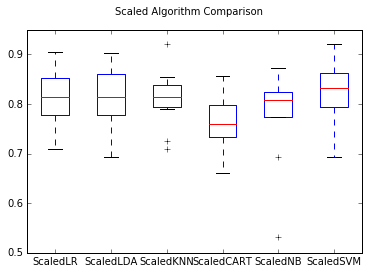

In [42]:
# split training data set into 70% (for training algorithm) and 30% (for cross validation)

from sklearn.model_selection import train_test_split

validation_size = 0.30
seed = 6
X_train, X_validation, Y_train, Y_validation = train_test_split(train, train_y, test_size 
                                               = validation_size, random_state = seed)
# standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression())])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()), ('KNN', KNeighborsClassifier())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))
pipelines.append(('ScaledSVM', Pipeline([('Scaler', StandardScaler()), ('SVM', SVC())])))

from sklearn.metrics import accuracy_score
results = []
names = []
scoring = 'accuracy'
num_folds = 10
seed = 7

for name, model in pipelines:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv = kfold, scoring = 'accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)    

# compare algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [43]:
# tune scaled LR
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
penalty_value = ['l1', 'l2']
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0, 10, 20]
param_grid = dict(penalty = penalty_value, C = c_values)
model = LogisticRegression()
kfold = KFold(n_splits = num_folds, random_state = seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("results from scaled LR are %f (%f) with: %r" % (mean, stdev, params))

Best: 0.821830 using {'penalty': 'l1', 'C': 1.5}


In [44]:
# tune scaled SVM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5, 1.7, 2.0]
kernel_values = ['linear', 'poly', 'rbf', 'sigmoid']
param_grid = dict(C=c_values, kernel= kernel_values)
model = SVC()
kfold = KFold(n_splits = num_folds, random_state = seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("results from scaled SVM are %f (%f) with: %r" % (mean, stdev, param))

Best: 0.826645 using {'kernel': 'rbf', 'C': 0.5}


In [45]:
# ensemble methods
ensembles = []
ensembles.append(('AB', AdaBoostClassifier()))
ensembles.append(('GBM', GradientBoostingClassifier()))
ensembles.append(('RF', RandomForestClassifier()))
ensembles.append(('ET', ExtraTreesClassifier()))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits = num_folds, random_state = seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring = scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" %(name, cv_results.mean(), cv_results.std())
    print(msg)

AB: 0.787916 (0.054924)
GBM: 0.815182 (0.055532)
RF: 0.805684 (0.043854)
ET: 0.787839 (0.069043)


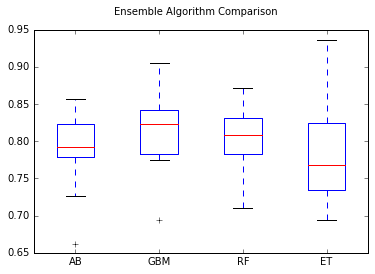

In [46]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Ensemble Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [47]:
# tuned GMB
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
loss_values = ['deviance', 'exponential']
n_estimators_value = [100, 200, 300, 400, 500]
min_samples_split_value = [1, 2]
max_features_value = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
param_grid = dict(loss = loss_values, n_estimators = n_estimators_value,
                  min_samples_split = min_samples_split_value, max_features = max_features_value)
model = GradientBoostingClassifier()
kfold = KFold(n_splits = num_folds, random_state = seed)
grid = GridSearchCV(estimator = model, param_grid = param_grid, scoring = 'accuracy', cv = kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
 #   print("results from scaled SVM are %f (%f) with: %r" % (mean, stdev, param))

Best: 0.834671 using {'n_estimators': 200, 'min_samples_split': 1, 'max_features': 7, 'loss': 'deviance'}


In [48]:
# tuned Random Forest
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
parameter_grid = {
                 'max_depth' : [4,5,6,7,8],
                 'n_estimators': [50, 100, 150, 200, 210, 240, 250, 300, 400, 500],
                 'criterion': ['gini','entropy']
                 }
model = RandomForestClassifier(max_features='sqrt')
grid = GridSearchCV(model, param_grid=parameter_grid, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)
print("Best: %f using %s" %(grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
#    print("results from scaled SVM are %f (%f) with: %r" % (mean, stdev, param))

Best: 0.829856 using {'n_estimators': 240, 'max_depth': 5, 'criterion': 'entropy'}


### Step 9, Finalize models
#### Check accuracy on validation dataset using optimized algorithms

In [55]:
# finalize logistic regression
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
scaler = StandardScaler().fit(X_validation)
rescaledX_validation = scaler.transform(X_validation)
modelLR = LogisticRegression(penalty = 'l1', C = 1.5)
modelLR.fit(rescaledX, Y_train)
y_pred = modelLR.predict(rescaledX_validation)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_validation, predictions)
print("Accuracy: %.2f%%"%(accuracy*100.0))

Accuracy: 84.70%


In [56]:
# finalize model_SVC
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
scaler = StandardScaler().fit(X_validation)
rescaledX_validation = scaler.transform(X_validation)
modelSVC = SVC(C = 0.5, kernel = 'rbf')
modelSVC.fit(rescaledX, Y_train)
y_pred = modelSVC.predict(rescaledX_validation)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_validation, predictions)
print("Accuracy: %.2f%%"%(accuracy*100.0))

Accuracy: 83.96%


In [58]:
# finalize model_GBM
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
scaler = StandardScaler().fit(X_validation)
rescaledX_validation = scaler.transform(X_validation)
modelGBM = GradientBoostingClassifier(loss = 'deviance', n_estimators = 200, 
                                   min_samples_split = 1, max_features = 7)
modelGBM.fit(rescaledX, Y_train)
y_pred = modelGBM.predict(rescaledX_validation)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_validation, predictions)
print("Accuracy: %.2f%%"%(accuracy*100.0)) 

Accuracy: 82.46%


In [60]:
# finalize model_random Forest
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
scaler = StandardScaler().fit(X_validation)
rescaledX_validation = scaler.transform(X_validation)
modelRF = RandomForestClassifier(criterion = 'entropy', n_estimators = 240, max_depth = 5)
modelRF.fit(rescaledX, Y_train)
y_pred = modelRF.predict(rescaledX_validation)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(Y_validation, predictions)
print("Accuracy: %.2f%%"%(accuracy*100.0)) 

Accuracy: 86.19%


### Step 10, Finalize model and output results

In [65]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 891 to 1308
Data columns (total 18 columns):
Sex              418 non-null float64
Age              418 non-null float64
SibSp            418 non-null float64
Parch            418 non-null float64
Fare             418 non-null float64
Title_Master     418 non-null float64
Title_Miss       418 non-null float64
Title_Mr         418 non-null float64
Title_Mrs        418 non-null float64
Title_Officer    418 non-null float64
Title_Royalty    418 non-null float64
Embarked_C       418 non-null float64
Embarked_Q       418 non-null float64
Embarked_S       418 non-null float64
Pclass_1         418 non-null float64
Pclass_2         418 non-null float64
Pclass_3         418 non-null float64
FamilySize       418 non-null float64
dtypes: float64(18)
memory usage: 58.9 KB


In [73]:
# Give predictions on testing dataset

scaler = StandardScaler().fit(test)
rescaledtest = scaler.transform(test)
predictions = modelRF.predict(rescaledtest).astype(int)
test = pd.read_csv('test.csv', header = 0)
ids = test['PassengerId'].values

predictions_file = open("RF_Oct2017.csv", "w", newline='')
open_file_object = csv.writer(predictions_file)
open_file_object.writerow(["PassengerId","Survived"])
open_file_object.writerows(zip(ids, predictions))
predictions_file.close()
print('Done.')

Done.
